正在处理:  沪深300
正在处理:  300价值
正在处理:  中证红利


,名称,当前估值,分位点%,最小估值,10%%,20%%,30%%,40%%,50%%,60%%,70%%,80%%,90%%,最大估值,数据个数
PE,沪深300,17.48,81.19,9.94,11.69,12.46,13.26,14.12,14.75,15.25,16.09,17.33,18.57,25.69,540
DYR,沪深300,1.80,31.40,0.95,1.31,1.61,1.79,1.88,1.97,2.06,2.16,2.30,2.43,2.76,540
PE,300价值,9.22,43.15,6.66,7.76,8.34,8.85,9.11,9.45,9.98,10.75,11.32,12.18,19.14,527
DYR,300价值,3.51,81.44,1.57,2.05,2.53,2.70,2.85,3.03,3.20,3.31,3.48,3.70,4.01,527
PE,中证红利,10.74,36.44,7.52,9.00,10.05,10.48,10.88,11.52,12.12,12.77,13.51,14.74,24.77,527
DYR,中证红利,4.79,85.59,1.76,2.73,3.03,3.26,3.36,3.53,3.76,4.02,4.29,5.19,6.60,527


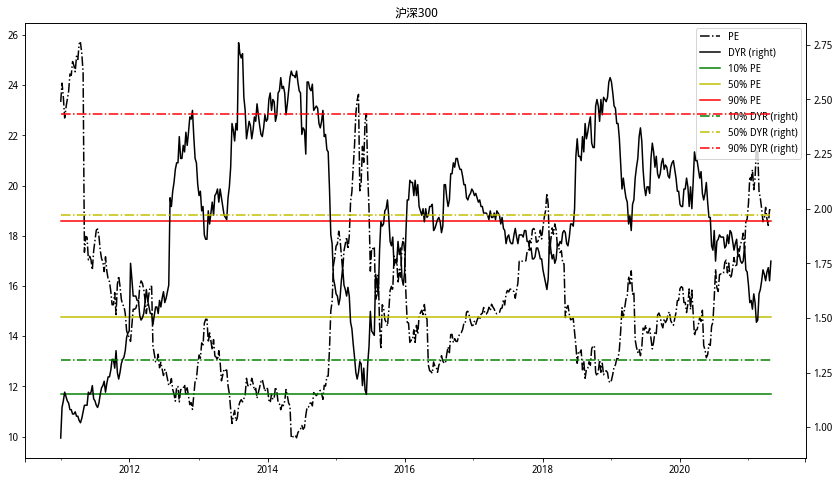

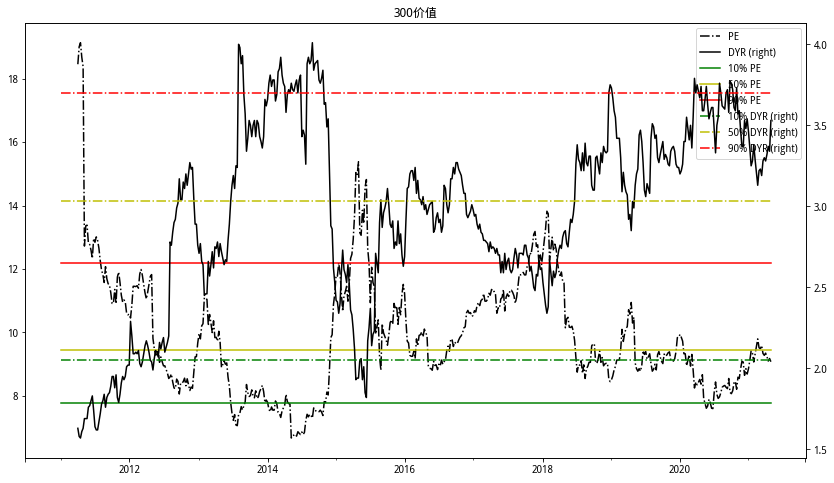

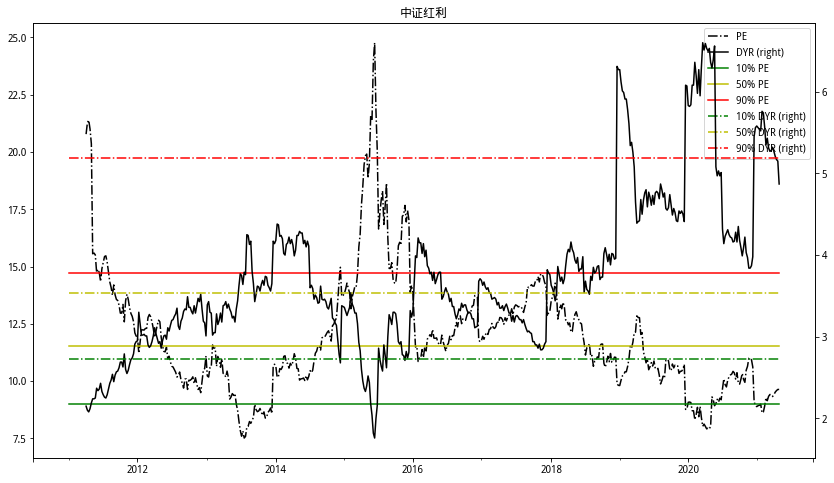

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bisect
import datetime

from jqdata import jy
from jqdata import *

import warnings
warnings.filterwarnings("ignore")


def get_index_quote(code,start_date=None, end_date=None,count=None):
    '''获取中证指数行情,返回panel结构'''
    if isinstance(code,str):
        code=[code]
    code.sort()
    code = [x[:6] for x in code]
    days = get_trade_days(start_date, end_date, count)
    code_df = jy.run_query(query(
         jy.SecuMain.InnerCode,jy.SecuMain.SecuCode,jy.SecuMain.ChiName
        ).filter(
        jy.SecuMain.SecuCode.in_(code)).order_by(jy.SecuMain.SecuCode))
    
    df = jy.run_query(query(
             jy.QT_CSIIndexQuote).filter(
            jy.QT_CSIIndexQuote.IndexCode.in_(code_df.InnerCode),
            jy.QT_CSIIndexQuote.TradingDay.in_(days),
            ))
    df2  = pd.merge(code_df, df, left_on='InnerCode',right_on='IndexCode').set_index(['TradingDay','SecuCode'])
    
    df2.drop(['InnerCode','IndexCode','ID','UpdateTime','JSID','OpenInterest','SettleValue','IndexCSIType'],
             axis=1,inplace=True)
    
    return df2

#指定日期的指数PE
def get_index_pe_date(index_code,date):
    quote = get_index_quote(index_code, end_date=date.strftime('%Y-%m-%d'), count=1)
    return float(quote['IndexPERatio2'].mean())

#指定日期的指数股息率
def get_index_dyr_date(index_code,date):
    quote = get_index_quote(index_code, end_date=date.strftime('%Y-%m-%d'), count=1)
    return float(quote['IndexDYRatio2'].mean())

    
#指数历史PE DYR
def get_index_pe_dyr(index_code):
    start='2011-1-1'
    end = pd.datetime.today() - datetime.timedelta(1);
    dates=[]
    pes=[]
    dyrs=[]
    for d in pd.date_range(start,end,freq='W'): #频率为周
        dates.append(d)
        pes.append(get_index_pe_date(index_code,d))
        dyrs.append(get_index_dyr_date(index_code,d))
    d = {
            'PE' : pd.Series(pes, index=dates),
            'DYR' : pd.Series(dyrs, index=dates)
        }
    DYR_PE = pd.DataFrame(d)
    return DYR_PE


all_index = get_all_securities(['index'])

index_choose = [
    #'399902.XSHE', # 中证流通
    #'000016.XSHG', # 上证50',     #110003.OF 易方达上证50指数
    '000300.XSHG', # :'沪深300',    #000176.OF 嘉实沪深300增强
    #'000905.XSHG', # :'中证500',    #000478.OF 建信中证500增强
    '000919.XSHG', #:'300价值',    #310398.OF 申万沪深300价值
    '000922.XSHG', #:'中证红利',   #100032.OF 富国中证红利
    #'000015.XSHG', # 上证红利 
    #'399702.XSHE', #:'深证F120',   #070023.OF 嘉实深F120基本面联接
    #'399978.XSHE', #:'中证医药100',#001550.OF 天弘中证医药100
    #'399812.XSHE',  #:'中证养老'    #000968.OF 广发中证养老指数
    #'000932.XSHG', # 中证消费
    #'399106.XSHE', # 深证综指
    #'399316.XSHE', # 巨潮小盘
]

df_pe_dyr = pd.DataFrame()
frames =pd.DataFrame()
today = pd.datetime.today() - datetime.timedelta(1)

for code in index_choose:
    index_name = all_index.ix[code].display_name  
    print('正在处理: ', index_name)   
    df_pe_dyr = get_index_pe_dyr(code)    
    
    results=[]
    pe = get_index_pe_date(code, today)
    q_pes = [df_pe_dyr['PE'].quantile(i / 10.0)  for i in range(11)]    
    idx = bisect.bisect(q_pes, pe)
    quantile = idx - (q_pes[idx] - pe) / (q_pes[idx] - q_pes[idx-1])   
    #index_name = all_index.ix[code].display_name
    results.append([index_name,
                    format(pe, '.2f'),
                    format(quantile * 10, '.2f')] + 
                    [format(q, '.2f')  for q in q_pes] + 
                    [df_pe_dyr['PE'].count()])
    
    dyr = get_index_dyr_date(code, today)
    q_dyrs = [df_pe_dyr['DYR'].quantile(i / 10.0)  for i in range(11)] 
    idx = bisect.bisect(q_dyrs, dyr)
    quantile = idx - (q_dyrs[idx] - dyr) / (q_dyrs[idx] - q_dyrs[idx-1])   
    #index_name = all_index.ix[code].display_name
    results.append([index_name,
                    format(dyr, '.2f'),
                    format(quantile * 10, '.2f')] + 
                    [format(q, '.2f')  for q in q_dyrs] + 
                    [df_pe_dyr['DYR'].count()])
    
    
    df_pe_dyr['10% PE']=q_pes[1]
    df_pe_dyr['50% PE']=q_pes[5]
    df_pe_dyr['90% PE']=q_pes[9]
    df_pe_dyr['10% DYR']=q_dyrs[1]
    df_pe_dyr['50% DYR']=q_dyrs[5]
    df_pe_dyr['90% DYR']=q_dyrs[9]

    plt.rcParams['font.sans-serif']=['SimHei']
    df_pe_dyr.plot(secondary_y=['DYR','10% DYR','50% DYR','90% DYR'],
                  figsize=(14,8), title = index_name,
                  style=['k-.', 'k', 'g', 'y', 'r', 'g-.', 'y-.', 'r-.']) 
    
    columns=['名称', '当前估值', '分位点%', '最小估值'] + \
            [format(i * 10, 'd') + '%%' for i in range(1,10)] + \
            ['最大估值' , '数据个数']
    
    df= pd.DataFrame(data = results,
                     index = ['PE','DYR'],
                     columns = columns)
    frames = pd.concat([frames, df])

frames  